In [2]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from typing import Callable

from mri_data import file_manager as fm

## Load Data

In [3]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/gradient_analysis")
r_dataroot = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/R_data")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")
df = df.join([choroid_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df['cortical_thickness_inv'] = 1 / df['cortical_thickness']
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [16]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ignore_structs1 = ["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2['anterior'] = df['AV_2']
    df2['ventral'] = df['VA_4'] + df['VLa_5'] + df['VLP_6'] + df['VPL_7']
    df2['medial'] = df['MD_Pf_12'] + df['CM_11'] 
    df2['posterior'] = df['Pul_8'] + df['LGN_9'] + df['MGN_10']
    df2['THALAMUS_1'] = df['THALAMUS_1']
    return df2

mni_combined_dists = pd.read_csv('/home/srs-9/Projects/ms_mri/data/mni_combined_nuclei_centroid_centroid_dists.csv', index_col="index")

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

choroid_dists1 = pd.read_csv(data_dir / "centroid-choroid_centroid2.csv", index_col="subid")
dists_newcols = {str(i): f"{hips_thomas_ref[i]}_dist" for i in hips_thomas_ref.index}
choroid_dists1 = choroid_dists1.rename(columns=dists_newcols)
choroid_dists1_z = choroid_dists1.apply(stats.zscore, nan_policy="omit")

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.rename(columns=dists_newcols)
choroid_dists_z = choroid_dists.apply(stats.zscore, nan_policy="omit")

choroid_dists_right = pd.read_csv(data_dir / "centroid-choroid_centroid-right.csv", index_col="subid")
choroid_dists_right = choroid_dists_right.rename(columns=dists_newcols)
choroid_dists_right_z = choroid_dists_right.apply(stats.zscore, nan_policy="omit")

choroid_dists2 = pd.DataFrame()
choroid_dists2['ventral_dist'] = choroid_dists[["VA_4_dist", "VLa_5_dist", "VLP_6_dist", "VPL_7_dist"]].mean(axis=1)
choroid_dists2['posterior_dist'] = choroid_dists[["Pul_8_dist", "LGN_9_dist", "MGN_10_dist"]].mean(axis=1)
choroid_dists2['medial_dist'] = choroid_dists[["MD_Pf_12_dist", "CM_11_dist", "MGN_10_dist"]].mean(axis=1)
choroid_dists2['anterior_dist'] = choroid_dists["AV_2_dist"]
choroid_dists2_z = choroid_dists2.apply(stats.zscore, nan_policy="omit")


choroid_dists_right2 = pd.DataFrame()
choroid_dists_right2['ventral_dist'] = choroid_dists_right[["VA_4_dist", "VLa_5_dist", "VLP_6_dist", "VPL_7_dist"]].mean(axis=1)
choroid_dists_right2['posterior_dist'] = choroid_dists_right[["Pul_8_dist", "LGN_9_dist", "MGN_10_dist"]].mean(axis=1)
choroid_dists_right2['medial_dist'] = choroid_dists_right[["MD_Pf_12_dist", "CM_11_dist", "MGN_10_dist"]].mean(axis=1)
choroid_dists_right2['anterior_dist'] = choroid_dists_right["AV_2_dist"]
choroid_dists_right2_z = choroid_dists_right2.apply(stats.zscore, nan_policy="omit")


ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

From `compute_exposures2.py`. This is what we want:

In [5]:
mni_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv", index_col="index")
mni_dists['struct'] = hips_thomas_ref
mni_ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_ventricle_exposures3.csv", index_col="index")
# choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/centroid-choroid_centroid.csv", index_col="subid")

## Functions

In [5]:
def regress_all_nuclei2(model_data, covariates, pred, structs):
    pvals = {}
    coefs = {}
    se = {}

    if not isinstance(pred, Callable):
        predictor = pred
        def pred(*args, **kwargs):
            return predictor

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{struct} ~ {pred(struct)} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[pred(struct)]
        coefs[struct] = res.params[pred(struct)]
        se[struct] = res.HC0_se[pred(struct)]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results

def dist_name(struct):
    return f"{struct}_dist"

## Save data for R

In [7]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
model_data = df_z.join([df_thomas_z, choroid_dists])

subids_remove = []
for col in choroid_dists.columns:
    check = model_data[col].abs()
    subids_remove.extend(check[check > 4].index.values)

subids_remove = set(subids_remove)

In [23]:
side = "left"

thomas_dfs = {"left": df_thomas_left, "right": df_thomas_right}
dist_files = {"left": "centroid-choroid_centroid-left.csv", "right": "centroid-choroid_centroid-right.csv"}

choroid_dists = pd.read_csv(data_dir / dist_files[side], index_col="subid")


choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")

model_data = df.join([thomas_dfs[side], choroid_dists])
# model_data = df.join([df_thomas, choroid_dists])
subids_remove = []
for col in choroid_dists.columns:
    check = model_data[col].abs()
    subids_remove.extend(check[check > 4].index.values)

subids_remove = set(subids_remove)

model_data = model_data.loc[~model_data.index.isin(subids_remove), :]
model_data = model_data.reset_index()

#! Edit this
model_data = model_data[model_data['dz_type2'].isin(["MS"])]
# model_data = model_data.loc[0:40, :]
choroid_dists = choroid_dists.loc[choroid_dists.index.isin(model_data.subid), :]

ventricle_dists = ventricle_dists.loc[ventricle_dists.index.isin(model_data.subid), :]

id_vars = ["dz_type3", "subid", "age", "Female", "tiv",  "choroid_volume", "dzdur", "THALAMUS_1", "cortical_thickness", "EDSS_sqrt", "SDMT"]
value_vars = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1'])].values
save_data = model_data.melt(id_vars=id_vars, value_vars=value_vars)
save_data = save_data.set_index(['subid', 'variable'])
for i, row in choroid_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "choroid_dist"] = row[ind]
for i, row in ventricle_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "ventricle_dist"] = row[ind]

save_data = save_data.reset_index()
# save_data = save_data[save_data['variable'].isin(hips_thomas_ref[thalamic_nuclei])]
# save_data = save_data[~save_data['variable'].isin(["Pul_8", "LGN_9"])]
# save_data.to_csv(r_dataroot / f"melted_data_for_R_MS-{side}.csv", index=False)

In [25]:
choroid_dists

,2,4,5,6,7,8,9,10,11,12,13,14,26,27,28,29,30,31,32
subid,,,,,,,,,,,,,,,,,,,
1001,-0.889817,-0.497860,-0.361518,-0.729810,-0.188696,0.558156,0.979795,0.799720,-0.177245,-0.626823,0.198463,-0.158987,-0.404040,-0.930314,-0.713613,-0.555385,-0.491305,-0.526979,0.449346
1002,-0.611355,-0.170847,-0.053692,-0.260234,-0.430334,-0.053268,0.605833,0.639856,-0.310815,-0.369538,-0.040393,0.363436,-0.088302,-0.050300,-0.389318,-0.159091,-0.106367,-0.220451,0.684445
1003,0.130895,0.303525,0.447442,0.229735,0.584120,0.298370,0.743327,0.491205,0.335631,0.313849,0.199204,0.308643,0.576111,-0.173476,0.309891,0.513061,0.712021,0.329953,0.433203
1004,-0.704431,-0.916267,-0.729972,-0.931381,-0.490686,-0.479670,0.461216,0.141540,-0.514166,-1.367321,-1.217516,-0.751755,-0.696096,-0.477468,0.351956,-0.599872,-0.641310,-0.370405,-0.694492
1005,-0.828432,-0.788575,-0.629202,-0.502505,-0.460731,-0.409580,-0.518002,-0.867039,-0.728270,-0.511717,-0.788942,-0.338570,-0.544374,-0.722695,-0.282257,-0.418048,-0.451389,-0.532001,-0.670789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,-0.546677,-0.786050,-0.900592,-0.588962,-0.870075,-0.959183,-1.067480,-1.585260,-0.850958,-0.398606,-1.255869,-1.043226,-0.973649,-0.478397,-0.495542,-0.892623,-0.966378,-0.877484,-1.552388
3017,-0.148882,0.697124,0.673801,0.443512,0.582448,0.656708,0.645477,0.843913,0.587167,0.433182,0.281512,0.929698,0.904324,0.441667,-0.033163,0.669348,0.939392,0.705108,0.744308
3021,0.225989,-0.454011,-0.468122,0.185474,-0.150033,-0.019838,-2.171648,-1.536030,-0.487996,0.111186,-0.508509,-0.943346,-0.844360,0.113066,-1.145182,-1.001045,-1.209176,-0.612753,-1.198188


In [29]:
side = "left"

thomas_dfs = {"left": df_thomas2_left_z, "right": df_thomas2_right_z}
dist = {"left": choroid_dists2, "right": choroid_dists_right2}

choroid_dists = dist[side]
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")


subids_remove = set(subids_remove)

model_data = df_z.join([thomas_dfs[side], choroid_dists])
# model_data = df.join([df_thomas, choroid_dists])

subids_remove = []
for col in choroid_dists.columns:
    check = model_data[col].abs()
    subids_remove.extend(check[check > 4].index.values)

model_data = model_data.loc[~model_data.index.isin(subids_remove), :]
model_data = model_data.reset_index()

#! Edit this
model_data = model_data[model_data['dz_type2'].isin(["MS"])]
# model_data = model_data.loc[0:40, :]
choroid_dists = choroid_dists.loc[choroid_dists.index.isin(model_data.subid), :]

ventricle_dists = ventricle_dists.loc[ventricle_dists.index.isin(model_data.subid), :]

id_vars = ["dz_type3", "subid", "age", "Female", "tiv",  "choroid_volume", "dzdur", "THALAMUS_1", "cortical_thickness", "EDSS_sqrt", "SDMT"]
# value_vars = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1'])].values
value_vars = df_thomas2.columns
save_data = model_data.melt(id_vars=id_vars, value_vars=value_vars)
save_data = save_data.set_index(['subid', 'variable'])
for i, row in choroid_dists.iterrows():
    for ind in row.index:
        struct = re.search(r"(.+)_dist", ind)[1]
        save_data.loc[(i, struct), "choroid_dist"] = row[ind]

save_data = save_data.reset_index()
# save_data = save_data[save_data['variable'].isin(hips_thomas_ref[thalamic_nuclei])]
# save_data = save_data[~save_data['variable'].isin(["Pul_8", "LGN_9"])]
save_data.to_csv(r_dataroot / f"melted_data_for_R_MS_z-grouped-{side}.csv", index=False)

In [27]:
choroid_dists

,ventral_dist,posterior_dist,medial_dist,anterior_dist
subid,,,,
1001,0.119436,1.213663,0.329816,-0.644178
1002,-0.750245,0.264265,-0.424293,-0.811858
1003,-0.242519,0.771709,-0.164785,-0.419437
1004,-0.682733,-0.520939,-0.568285,-0.486798
1005,-1.113589,-0.946741,-1.052239,-1.181587
...,...,...,...,...
3016,-1.343576,-1.431872,-1.627363,-1.041729
3017,-0.124892,0.426943,-0.209646,-0.794505
3021,0.633810,-0.516325,0.399602,0.799103


In [32]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
# model_data = df.join([df_thomas, choroid_dists])
model_data = df_z.join([df_thomas_z, choroid_dists])

check = model_data["2"].abs()
check[check > 4].index.values

array([1107, 2007])

## Analysis

In [8]:
model_data = df_z.join([df_thomas_left_z, choroid_dists_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
model_data = model_data.loc[~model_data.index.isin([1011]), :]
covariates = "Female + age + tiv"
structs = hips_thomas_ref[~hips_thomas_ref.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
# structs = hips_thomas_ref[hips_thomas_ref.index.isin(thalamic_nuclei)]

regression_results = regress_all_nuclei2(model_data, covariates, dist_name, structs)
# regression_results['dists'] = choroid_dists
regression_results

,struct,coef,pvals,se,p_fdr,coef_sig
2,AV_2,0.151848,3.842647e-04,0.046443,6.084191e-04,0.151848
4,VA_4,0.099729,1.207349e-02,0.040235,1.433727e-02,0.099729
5,VLa_5,0.119714,2.934377e-03,0.038008,3.716877e-03,0.119714
6,VLP_6,0.156042,1.822045e-04,0.040242,3.461885e-04,0.156042
7,VPL_7,0.169109,3.058344e-05,0.041481,6.456505e-05,0.169109
8,Pul_8,0.172796,2.717919e-05,0.034850,6.455057e-05,0.172796
9,LGN_9,0.472606,2.409639e-27,0.055693,4.578315e-26,0.472606
10,MGN_10,0.362542,5.360697e-21,0.041025,5.092662e-20,0.362542
11,CM_11,0.199739,1.206519e-06,0.039101,4.584771e-06,0.199739
12,MD_Pf_12,0.183792,2.485566e-05,0.046492,6.455057e-05,0.183792


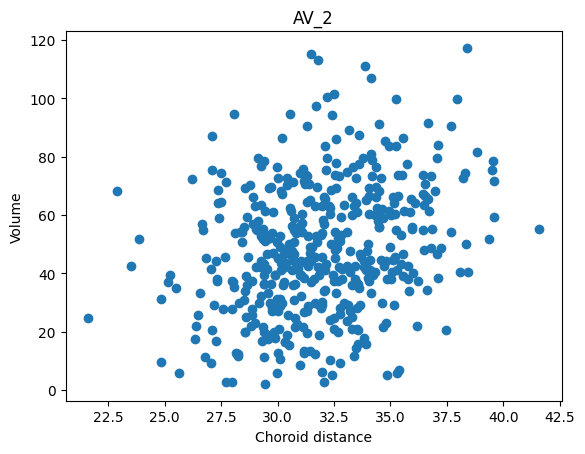

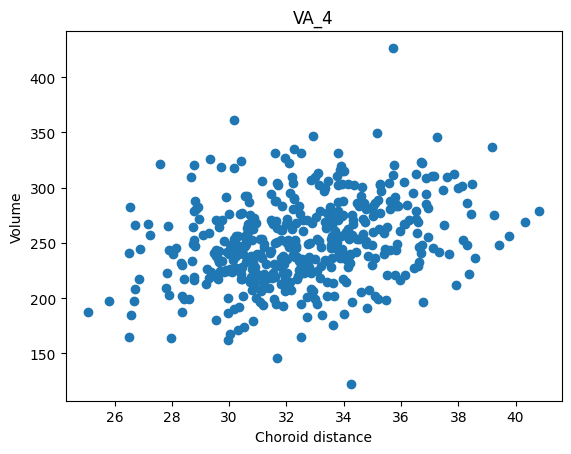

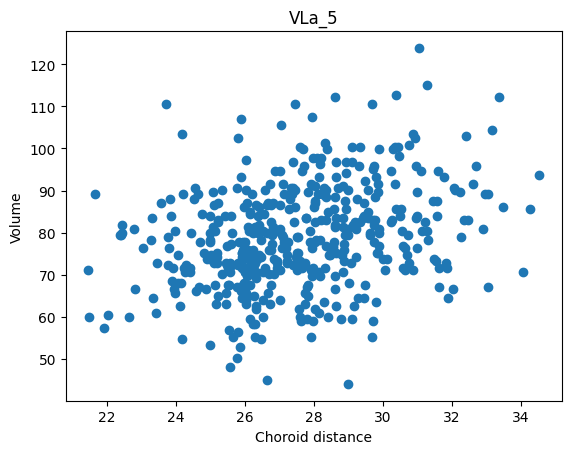

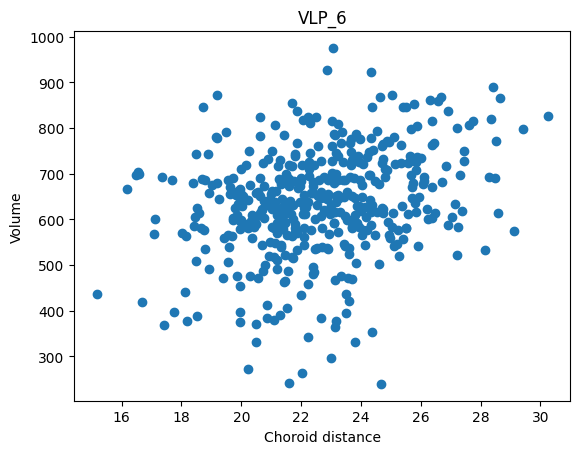

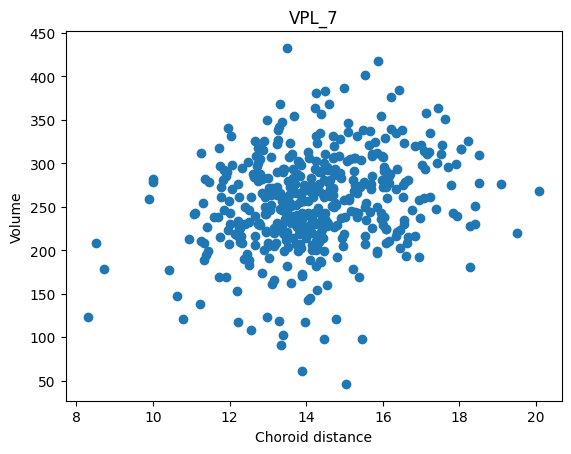

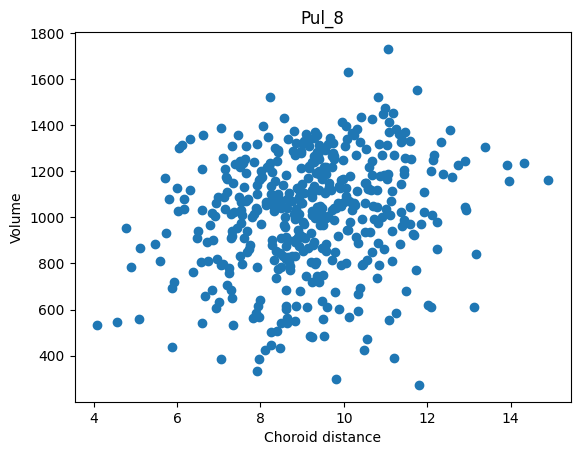

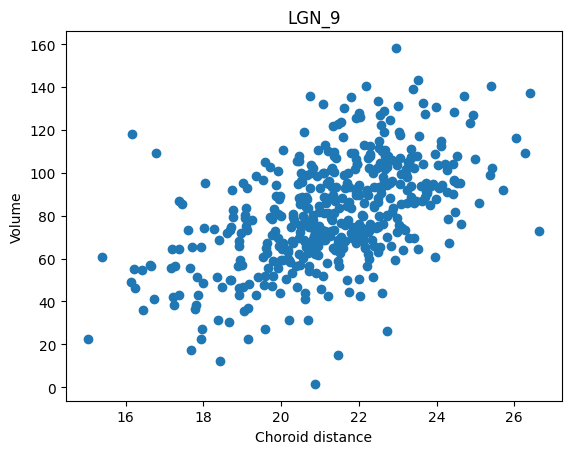

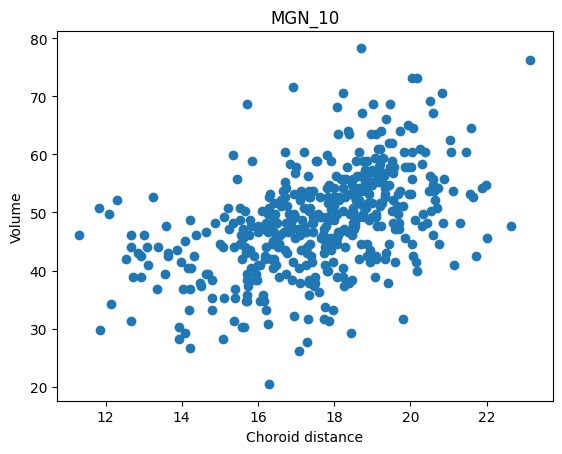

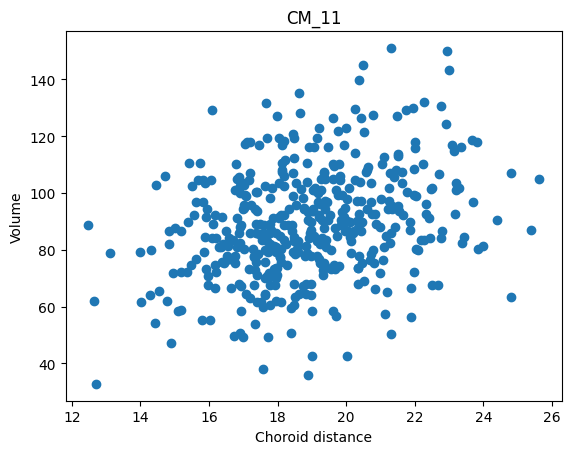

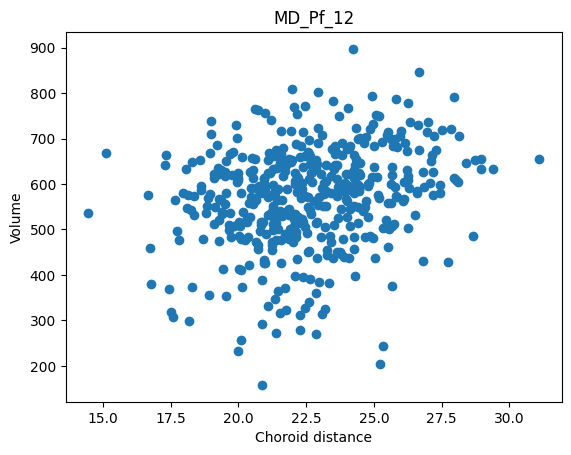

In [51]:
model_data = df.join([df_thomas_left, choroid_dists])
model_data = model_data[model_data.dz_type2 == "MS"]
model_data = model_data.loc[~model_data.index.isin([2007]), :]

subids_remove = []
for col in choroid_dists.columns:
    check = choroid_dists_z[col].abs()
    subids_remove.extend(check[check >= 3].index.values)

subids_remove = set(subids_remove)
model_data = model_data.loc[~model_data.index.isin(subids_remove), :]

for ind in hips_thomas_ref[thalamic_nuclei].index:
    dist_name = f"{hips_thomas_ref[ind]}_dist"
    struct = hips_thomas_ref[ind]
    plt.scatter(model_data[dist_name], model_data[struct])
    plt.xlabel("Choroid distance")
    plt.ylabel("Volume")
    plt.title(struct)
    plt.show()

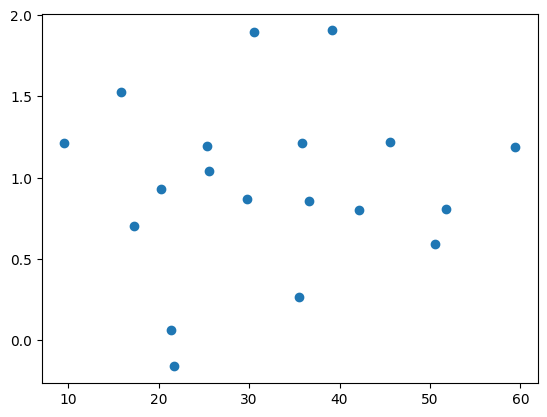

In [49]:
subid = 1012

struct_inds = hips_thomas_ref[~hips_thomas_ref.isin(["THALAMUS_1", "Amy_34", "GP_33"])].index

check = df_thomas_z.loc[subid, hips_thomas_ref[struct_inds]]
check.index = hips_thomas_ref[struct_inds].index

dist_index = hips_thomas_ref.copy()
for i, row in dist_index.items():
    dist_index[i] = f"{row}_dist"

x = choroid_dists.loc[subid, dist_index[struct_inds]]
x.index = dist_index[struct_inds].index

plt.scatter(x, check)

In [39]:
dist_index[2] = f"{dist_index[2]}_dist"
dist_index

index
1     THALAMUS_1
2      AV_2_dist
4           VA_4
5          VLa_5
6          VLP_6
7          VPL_7
8          Pul_8
9          LGN_9
10        MGN_10
11         CM_11
12      MD_Pf_12
13         Hb_13
14        MTT_14
26        Acc_26
27        Cau_27
28        Cla_28
29        GPe_29
30        GPi_30
31        Put_31
32         RN_32
33         GP_33
34        Amy_34
Name: struct, dtype: object

(array([ 54., 339., 160.,  15.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([ 4.080737  ,  7.00859947,  9.93646194, 12.86432442, 15.79218689,
        18.72004936, 21.64791183, 24.5757743 , 27.50363678, 30.43149925,
        33.35936172]),
 <BarContainer object of 10 artists>)

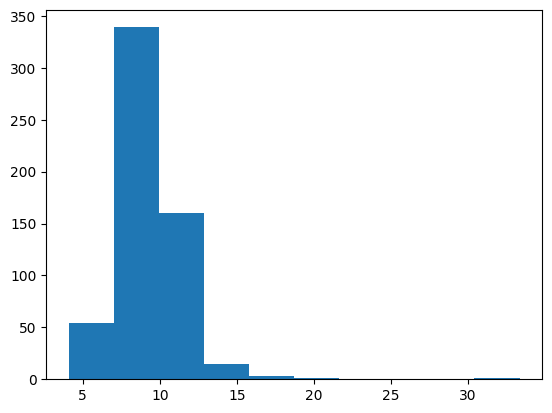

In [10]:
ind = 8
dist_name = f"{hips_thomas_ref[ind]}_dist"
struct = hips_thomas_ref[ind]
plt.hist(choroid_dists[dist_name])

In [104]:
model_data.sort_values(by="Pul_8_dist")

,subject,sz_onset,dzdur,MSSS,gMSSS,ARMSS,sex,age,obs_start_date,obs_end_date,...,MD_Pf_12_dist,Hb_13_dist,MTT_14_dist,Acc_26_dist,Cau_27_dist,Cla_28_dist,GPe_29_dist,GPi_30_dist,Put_31_dist,RN_32_dist
subid,,,,,,,,,,,,,,,,,,,,,
2021,ms2021,11/1/2020,-1.301885,NaN,NaN,-0.532257,Female,-1.039421,8/30/2019,8/30/2019,...,20.882586,19.336411,34.341098,52.313848,43.998270,45.343293,36.896778,34.224295,39.861209,29.184167
1267,ms1267,12/27/2019,-1.084497,0.376012,0.151097,0.490655,Female,-1.755396,1/5/2021,1/5/2021,...,22.416332,18.423869,36.152331,58.384649,51.299097,52.252689,42.631012,39.501381,46.404346,29.431954
1477,ms1477,3/28/2021,-1.106668,-0.380526,-0.467743,-0.099323,Female,-1.962233,1/15/2022,1/15/2022,...,17.993560,18.669202,32.840351,52.772773,42.512913,46.879048,36.470242,34.570958,40.559010,29.989264
2001,ms2001,1/1/2011,-0.595915,-0.425267,-0.359028,-0.977924,Female,0.570860,12/22/2016,12/22/2016,...,15.771339,14.228181,29.819238,53.049016,43.907741,49.172222,38.375681,36.429051,42.983207,26.469768
1364,ms1364,6/1/2010,-0.485328,NaN,NaN,NaN,Female,-1.441162,7/5/2017,7/5/2017,...,21.016838,18.195327,35.705125,56.720618,50.081460,53.190906,42.230788,39.616385,46.549528,29.968650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,ms1072,1/1/2015,-0.844937,-0.014459,0.013113,-0.052635,Female,-0.938212,6/15/2018,6/15/2018,...,27.561817,20.807361,37.264459,61.938615,56.416127,66.759256,52.383268,48.914150,59.773203,31.557970
2007,ms2007,6/1/2005,0.042460,-0.852345,-0.844065,-0.850591,Female,0.224143,11/8/2017,11/8/2017,...,17.527839,21.345345,25.114760,40.626305,33.803083,52.181034,36.006878,35.056401,43.645553,28.786253
1068,ms1068,1/1/1996,1.082353,-0.067335,0.126009,0.524610,Female,0.765764,12/20/2018,12/20/2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([  3.,  18.,  29.,  62., 111., 118.,  80.,  37.,   8.,   1.]),
 array([  62.970985 ,  391.9818211,  720.9926572, 1050.0034933,
        1379.0143294, 1708.0251655, 2037.0360016, 2366.0468377,
        2695.0576738, 3024.0685099, 3353.079346 ]),
 <BarContainer object of 10 artists>)

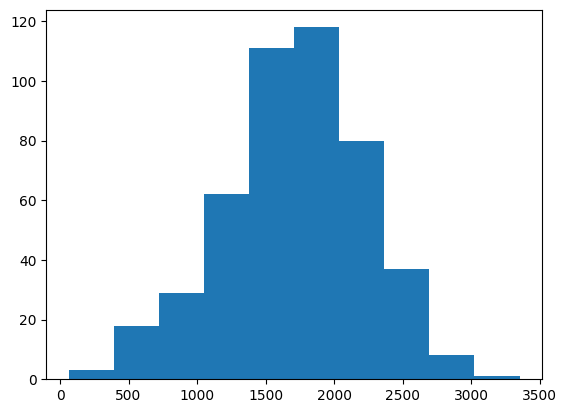

In [102]:
plt.hist(model_data['choroid_volume'])